# <a id='toc1_'></a>[MLP pour le texte](#toc0_)
Modèle Perceptron multicouche

## <a id='toc1_1_'></a>[Paramètres des jeux de données](#toc0_)

Veuillez renseigner les paramètres ci-dessous pour définir les jeux de données.

In [1]:
# Version de Python utilisée : 3.9.xx
# Import des librairies
import os
import gc
import pandas as pd
pd.set_option('display.max_colwidth', None)


import matplotlib.pyplot as plt


# Define the dataset size
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2

# Define the text preproc
TEXT_PREPROC = "Tfidf_default_with_stem"

# list des configuration preproc:
# 'BoW_default'   Bag of Words with default input parameters + remove html + remove numeric words.
# 'Tfidf_default' Tfidf with default input parameters + remove html + remove numeric words.
# 'Tfidf_specific' Tfidf with specific input parameter: 'min_df': 0.001 + remove html + remove numeric words.
# 'BoW_default_with_stem'  Bag of Words with default input parameters + remove html + remove numeric words + french stemming.
# 'Tfidf_default_with_stem' Tfidf with default input parameters + remove html + remove numeric words + french stemming.
# 'Tfidf_specific_with_stem' Tfidf with specific input parameter: 'min_df': 0.001 + remove html + remove numeric words + french stemming.

# Define the text model
TEXT_MODEL = "MultinomialNB"
# MultinomialNB
# SGDClassifier
# RandomForestClassifier
# GradientBoostingClassifier

IS_LOCAL = True

# save data into a pickle file
SAVE_SPARSE_DATA = True 

if  IS_LOCAL:
    # Checkpoint directory and paths
    CHECKPOINT_DIR = os.path.join("data", "models", "mlp_text")
    CHECKPOINT_PATH = os.path.join(CHECKPOINT_DIR, "cp_{val_loss:.2f}-{val_accuracy:.2f}-.ckpt")

    # Path to the history CSV file to store training metrics
    HIST_CSV_PATH = os.path.join(CHECKPOINT_DIR, "history.csv")


## <a id='toc1_2_'></a>[Génération des jeux de données](#toc0_)

Veuillez executer la cellule ci-dessous. Attention, l'étape de pré-processing du text peut être longue si vous avez un gros jeu de données. 

In [2]:
from sklearn.model_selection import train_test_split
from src.data import data


In [3]:
# Importer des fichiers contenant les données
df = data.load_data("data").fillna("")

# Data
features = df['designation']+" "+df['description']
target = df['prdtypecode']

# Dplit train et test
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=123, test_size=TEST_SIZE, train_size=TRAIN_SIZE)

# difference avec precedent notebook  !!!!!
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=123, test_size=0.2, train_size=0.8)

# Definition du nom du dataframe (mandatory)
X_train.name = 'X_train'
X_test.name = 'X_test'
X_valid.name = 'X_valid'

## <a id='toc1_3_'></a>[Pre-processing & vectorisation pipelines](#toc0_)

In [4]:
import pickle
import tensorflow as tf
import numpy as np

from src.data.vectorization_pipeline import BagOfWordsDefault
from src.data.vectorization_pipeline import TfidfDefault
from src.data.vectorization_pipeline import TfidfV1
from src.data.vectorization_pipeline import BOW_Stemming
from src.data.vectorization_pipeline import TfidfStemming
from src.data.vectorization_pipeline import TfidfStemmingV1
from src.data.text_preproc_pipeline import TextPreprocess

import scipy.sparse as sparse

In [5]:
text_preprocessing = {'BoW_default':BagOfWordsDefault(),
                      'Tfidf_default':TfidfDefault(),
                      'Tfidf_specific':TfidfV1(),
                      'BoW_default_with_stem':BOW_Stemming(),
                      'Tfidf_default_with_stem':TfidfStemming(),
                      'Tfidf_specific_with_stem':TfidfStemmingV1()}

text_preproc = text_preprocessing[TEXT_PREPROC]

INFO:textpipeline:class:BagOfWordsDefault
INFO:textpipeline:class:TfidfDefault
INFO:textpipeline:class:TfidfV1
INFO:textpipeline:class:BOW_Stemming
INFO:textpipeline:class:TfidfStemming
INFO:textpipeline:class:TfidfStemmingV1


In [7]:
_preproc = TextPreprocess(text_preproc)
_preproc.fit(X_train)

X_train_preproc = _preproc.transform(X_train)
X_test_preproc = _preproc.transform(X_test)
X_valid_preproc = _preproc.transform(X_valid) # difference avec precedent notebook  !!!!!

# Sauvegarde en matrice sparse 
if SAVE_SPARSE_DATA:
    print('Save')
    filenames = {}
    filenames['feat_train_filename'] = _preproc.save(X_train_preproc, "data/training/X_train_")
    filenames['feat_test_filename'] = _preproc.save(X_test_preproc, "data/training/X_test_")
    filenames['feat_valid_filename'] = _preproc.save(X_valid_preproc, "data/training/X_valid_") # difference avec precedent notebook  !!!!!

    filenames['target_train_filename'] = _preproc.save(y_train, "data/training/y_train")
    filenames['target_test_filename'] = _preproc.save(y_test, "data/training/y_test")
    filenames['target_valid_filename'] = _preproc.save(y_valid, "data/training/y_valid")
    
    filenames['voc_filename'] = _preproc.save_voc("data/training/voc_")

    file_name = f"data/training/{TEXT_PREPROC}_filenames.pkl"
    with open(file_name,'wb') as fp:
        pickle.dump(filenames, fp)

else:
    # don't save
    X_apprentissage = sparse.csr_matrix(X_train_preproc)
    X_test = sparse.csr_matrix(X_test_preproc)
    y_apprentissage = np.asarray(y_train)

    del X_train_preproc
    del X_test_preproc
    gc.collect()




INFO:textpipeline:TextPreprocess.fit X_train 197.08 seconds
INFO:textpipeline:TextPreprocess.transform X_train 149.10 seconds
INFO:textpipeline:TextPreprocess.transform X_test 36.92 seconds
INFO:textpipeline:TextPreprocess.transform X_valid 29.62 seconds
INFO:textpipeline:TextPreprocess.save data/training/X_train__TfidfStemming.pkl 0.07 seconds
INFO:textpipeline:TextPreprocess.save data/training/X_test__TfidfStemming.pkl 0.01 seconds
INFO:textpipeline:TextPreprocess.save data/training/X_valid__TfidfStemming.pkl 0.01 seconds
INFO:textpipeline:TextPreprocess.save data/training/y_train_TfidfStemming.pkl 0.00 seconds
INFO:textpipeline:TextPreprocess.save data/training/y_test_TfidfStemming.pkl 0.00 seconds
INFO:textpipeline:TextPreprocess.save data/training/y_valid_TfidfStemming.pkl 0.00 seconds
INFO:textpipeline:TextPreprocess.save_voc size 75553
INFO:textpipeline:TextPreprocess.save_voc data/training/voc__TfidfStemming.pkl


Save


In [8]:
filenames

{'feat_train_filename': 'data/training/X_train__TfidfStemming.pkl',
 'feat_test_filename': 'data/training/X_test__TfidfStemming.pkl',
 'feat_valid_filename': 'data/training/X_valid__TfidfStemming.pkl',
 'target_train_filename': 'data/training/y_train_TfidfStemming.pkl',
 'target_test_filename': 'data/training/y_test_TfidfStemming.pkl',
 'target_valid_filename': 'data/training/y_valid_TfidfStemming.pkl',
 'voc_filename': 'data/training/voc__TfidfStemming.pkl'}

Charger les données en matrice creuse

In [137]:
if SAVE_SPARSE_DATA:
    # Chargement des matrices sparse
    X_train =  pickle.load(open(filenames['feat_train_filename'] , "rb"))
    y_train = pickle.load(open(filenames['target_train_filename'], "rb")) 

    X_test = pickle.load(open(filenames['feat_test_filename'], "rb"))
    y_test = pickle.load(open(filenames['target_test_filename'], "rb"))

    X_valid = pickle.load(open(filenames['feat_valid_filename'], "rb"))
    y_valid = pickle.load(open(filenames['target_valid_filename'], "rb"))


    y_train = np.asarray(y_train.todense().reshape(-1, 1))
    y_test = np.asarray(y_test.todense().reshape(-1, 1))
    y_valid = np.asarray(y_valid.todense().reshape(-1, 1))


In [167]:
label_origin = np.copy(y_train)


In [139]:
# Convertion des étiquettes en valeurs dans la plage [0, num_classes - 1]
y_temp = np.copy(y_train)
for i,c in enumerate(np.unique(y_temp)):
     y_train[y_temp==c] = i

y_temp = np.copy(y_test)
for i,c in enumerate(np.unique(y_temp)):
     y_test[y_temp==c] = i

y_temp = np.copy(y_valid)
for i,c in enumerate(np.unique(y_temp)):
     y_valid[y_temp==c] = i

print(np.unique(y_train))
print(np.unique(y_test))

assert(len(np.unique(y_test)) == len(np.unique(y_train)))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26]


In [140]:
# Fonction pour la convertion de la matrice creuse en matrice creuse tensorflow
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.sparse.reorder(tf.SparseTensor(indices, coo.data, coo.shape))


In [141]:
X_train = convert_sparse_matrix_to_sparse_tensor(X_train)
X_valid = convert_sparse_matrix_to_sparse_tensor(X_valid)
X_test = convert_sparse_matrix_to_sparse_tensor(X_test)

y_train = y_train.ravel()
y_valid = y_valid.ravel()
y_test = y_test.ravel()


In [142]:
import collections

counter = collections.Counter(y_train)
print('Train:', counter.most_common())
counter = collections.Counter(y_valid)
print('Valid:', counter.most_common())
counter = collections.Counter(y_test)
print('Test:', counter.most_common())


Train: [(23, 6566), (13, 3285), (21, 3236), (9, 3218), (16, 3151), (7, 3117), (19, 3033), (18, 3013), (14, 2729), (5, 2533), (12, 2088), (0, 2020), (25, 1777), (4, 1678), (22, 1638), (1, 1617), (24, 1605), (11, 1585), (8, 1336), (2, 1046), (20, 895), (26, 563), (10, 542), (17, 541), (3, 519), (15, 515), (6, 499)]
Valid: [(23, 1598), (13, 821), (9, 821), (7, 809), (18, 783), (16, 782), (19, 762), (21, 760), (14, 708), (5, 629), (12, 518), (0, 495), (25, 448), (4, 441), (22, 427), (1, 416), (11, 401), (24, 364), (8, 319), (2, 294), (20, 228), (26, 144), (3, 137), (17, 132), (6, 126), (15, 113), (10, 111)]
Test: [(23, 2045), (16, 1060), (9, 1006), (21, 993), (19, 979), (13, 967), (18, 964), (7, 944), (14, 866), (5, 791), (12, 635), (0, 601), (4, 552), (25, 536), (24, 527), (22, 524), (11, 505), (1, 475), (8, 415), (2, 341), (20, 298), (3, 176), (15, 175), (26, 165), (10, 154), (17, 151), (6, 139)]


## <a id='toc1_4_'></a>[Définition du MLP](#toc0_)

In [143]:
def get_last_layer_units_and_activation(num_classes):
    """Gets the # units and activation function for the last network layer.

    # Arguments
        num_classes: int, number of classes.

    # Returns
        units, activation values.
    """
    if num_classes == 2:
        activation = 'sigmoid'
        units = 1
    else:
        activation = 'softmax'
        units = num_classes
    return units, activation

In [168]:
from tensorflow.python.keras import models
from tensorflow.python.keras.layers import Dense, InputLayer
from tensorflow.python.keras.layers import Dropout

def mlp_model(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(InputLayer(input_shape=(input_shape),sparse=True))

    for _ in range(layers-1):
        model.add(Dense(units=units, activation='relu'))
        model.add(Dropout(rate=dropout_rate))


    model.add(Dense(units=op_units, activation=op_activation))
    return model

def mlp_model2(layers, units, dropout_rate, input_shape, num_classes):
    """Creates an instance of a multi-layer perceptron model.

    # Arguments
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of the layers.
        dropout_rate: float, percentage of input to drop at Dropout layers.
        input_shape: tuple, shape of input to the model.
        num_classes: int, number of output classes.

    # Returns
        An MLP model instance.
    """
    op_units, op_activation = get_last_layer_units_and_activation(num_classes)
    model = models.Sequential()
    model.add(InputLayer(input_shape=(input_shape),sparse=True))

    # model.add(Dense(units=2048, activation='relu',
    #                 kernel_regularizer=tf.keras.regularizers.L1(0.01),
    #                 activity_regularizer=tf.keras.regularizers.L2(0.01)
    #                 ))
    # model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=512, activation='relu',
                    #kernel_regularizer=tf.keras.regularizers.L1(0.01),
                    activity_regularizer=tf.keras.regularizers.L2(0.01)))
    #model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=128, activation='relu',
                    #kernel_regularizer=tf.keras.regularizers.L1(0.01),
                    activity_regularizer=tf.keras.regularizers.L2(0.01)))
    #model.add(Dropout(rate=dropout_rate))

    # model.add(Dense(units=64, activation='relu'))
    # model.add(Dropout(rate=dropout_rate))

    model.add(Dense(units=op_units, activation=op_activation))
    return model

In [145]:
from tensorflow.python.keras.optimizer_v2.adam import Adam

def train_ngram_model(data,
                      num_classes,
                      learning_rate=1e-3,
                      epochs=1000,
                      batch_size=128,
                      layers=2,
                      units=128, #64,
                      dropout_rate=0.2):
    """Trains n-gram model on the given dataset.

    # Arguments
        data: tuples of training and test texts and labels.
        learning_rate: float, learning rate for training model.
        epochs: int, number of epochs.
        batch_size: int, number of samples per batch.
        layers: int, number of `Dense` layers in the model.
        units: int, output dimension of Dense layers in the model.
        dropout_rate: float: percentage of input to drop at Dropout layers.

    # Raises
        ValueError: If validation data has label values which were not seen
            in the training data.
    """
    # Get the data.
    (train_dataset, train_labels), (val_dataset, val_labels) = data

    # Vectorize texts.
    x_train, x_val = train_dataset, val_dataset

    # Create model instance.
    model = mlp_model(layers=layers,
                    units=units,
                    dropout_rate=dropout_rate,
                    input_shape=x_train.shape[1],
                    num_classes=num_classes)

    # Compile model with learning parameters.
    if num_classes == 2:
        loss = 'binary_crossentropy'
    else:
        #loss = 'sparse_categorical_crossentropy'
        loss = 'categorical_crossentropy'
    optimizer = Adam(lr=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=['acc'])

    # Create callback for early stopping on validation loss. If the loss does
    # not decrease in two consecutive tries, stop training.
    callbacks = [
                tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=3,
                restore_best_weights=True),
                #start_from_epoch = 5,
                # Insert the metrics into a CSV file)
                tf.keras.callbacks.CSVLogger(HIST_CSV_PATH, separator=',', append=False)
                ]

    # Train and validate model.
    history = model.fit(
            x_train,
            train_labels,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(x_val, val_labels),
            verbose=2,  # Logs once per epoch.
            batch_size=batch_size)

    # Print results.
    history = history.history
    print('Validation accuracy: {acc}, loss: {loss}'.format(
            acc=history['val_acc'][-1], loss=history['val_loss'][-1]))

    # Save model.
    model.save('mlp_model_v2.h5')
    return history['val_acc'][-1], history['val_loss'][-1]

## <a id='toc1_5_'></a>[Apprentissage](#toc0_)

In [146]:
y_valid_encode = tf.keras.utils.to_categorical(y_valid)
y_train_encode = tf.keras.utils.to_categorical(y_train)

In [174]:
data = ((X_train,y_train_encode),(X_valid, y_valid_encode))
nb_classes = y_train_encode.shape[1]
train_ngram_model(data, nb_classes, layers=2, units=512/4) #units=512)

Epoch 1/1000


d:\Agnoli\Datascientest\Projet\Fev23_BDS_Rakuten\.conda\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_5/dense_11/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_5/dense_11/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_5/dense_11/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


425/425 - 35s - loss: 416.8392 - acc: 0.0767 - val_loss: 74.4165 - val_acc: 0.0484
Epoch 2/1000
425/425 - 33s - loss: 329.2356 - acc: 0.0634 - val_loss: 161.8278 - val_acc: 0.0458
Epoch 3/1000


In [102]:
data = ((X_train,y_train),(X_valid, y_valid))
train_ngram_model(data, layers=2)

Epoch 1/1000


d:\Agnoli\Datascientest\Projet\Fev23_BDS_Rakuten\.conda\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_11/dense_22/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_11/dense_22/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_11/dense_22/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


425/425 - 41s - loss: 1.7174 - acc: 0.6032 - val_loss: 0.9277 - val_acc: 0.7736
Epoch 2/1000


KeyboardInterrupt: 

   epoch       acc      loss   val_acc  val_loss
0      0  0.598289  1.716864  0.770001  0.906182
1      1  0.826148  0.673901  0.808420  0.662993
2      2  0.892134  0.407171  0.817325  0.607178
3      3  0.931015  0.267563  0.818724  0.590995
4      4  0.953298  0.185043  0.817031  0.600134
5      5  0.966731  0.134596  0.815412  0.614603
6      6  0.975471  0.101291  0.812615  0.637054


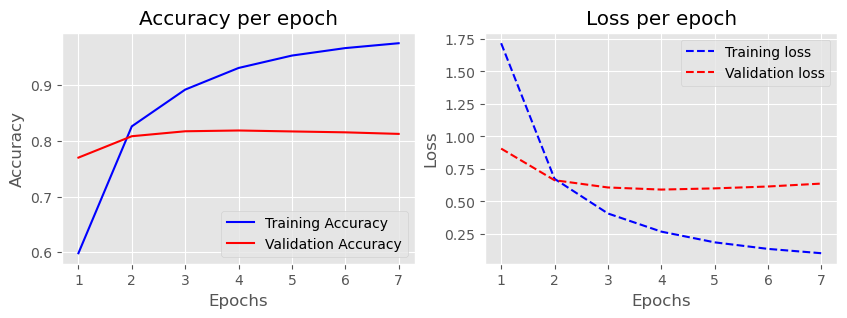

In [157]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

training_history = pd.read_csv(HIST_CSV_PATH, delimiter=",", header=0)
print(training_history)
fig = plt.figure(figsize=(10, 3))
ax1 = fig.add_subplot(121)

# Labels des axes
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')

# Courbe de la précision sur l'échantillon d'entrainement
ax1.plot(np.arange(1 , training_history["acc"].count() + 1, 1),
         training_history["acc"],
         label = 'Training Accuracy',
         color = 'blue')

# Courbe de la précision sur l'échantillon de test
ax1.plot(np.arange(1 , training_history["val_acc"].count() + 1, 1),
         training_history['val_acc'], 
         label = 'Validation Accuracy',
         color = 'red')

ax1.legend()
ax1.set_title("Accuracy per epoch")

ax2 = fig.add_subplot(122)
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax2.plot(np.arange(1 , training_history["loss"].count() + 1, 1),
         training_history['loss'], 
         label = 'Training loss',
         linestyle="dashed",
         color = 'blue')

ax2.plot(np.arange(1 , training_history["val_loss"].count() + 1, 1),
         training_history['val_loss'], 
         label = 'Validation loss',
         linestyle="dashed",
         color = 'red')

ax2.legend()
ax2.set_title("Loss per epoch")

# Affichage de la figure
plt.show()

**Table of contents**<a id='toc0_'></a>    
- [MLP pour le texte](#toc1_)    
  - [Paramètres des jeux de données](#toc1_1_)    
  - [Génération des jeux de données](#toc1_2_)    
  - [Pre-processing & vectorisation pipelines](#toc1_3_)    
  - [Définition du MLP](#toc1_4_)    
  - [Apprentissage](#toc1_5_)    
  - [Evaluation](#toc1_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_6_'></a>[Evaluation](#toc0_)

In [158]:
y_test_encode = tf.keras.utils.to_categorical(y_test)

In [161]:
# You can also evaluate or predict on a dataset.
# load model
new_model = tf.keras.models.load_model('mlp_model_v2.h5')
new_model.summary()
print("Evaluate")
loss, acc = new_model.evaluate(X_test, y_test_encode, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 128)               9670912   
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 27)                3483      
                                                                 
Total params: 9,674,395
Trainable params: 9,674,395
Non-trainable params: 0
_________________________________________________________________
Evaluate
531/531 - 2s - loss: 0.5910 - acc: 0.8144 - 2s/epoch - 3ms/step
Restored model, accuracy: 81.44%


In [162]:
y_pred_test = new_model.predict(X_test, verbose=2)

531/531 - 2s - 2s/epoch - 3ms/step


In [163]:
from  sklearn.metrics import classification_report,confusion_matrix
list_decision = []
for y in y_pred_test:
  list_decision.append(np.argmax(y))
y_pred_test_decision = np.array(list_decision)

print(classification_report(y_test, y_pred_test_decision))


              precision    recall  f1-score   support

           0       0.50      0.52      0.51       601
           1       0.65      0.64      0.65       475
           2       0.82      0.85      0.84       341
           3       0.95      0.84      0.89       176
           4       0.78      0.77      0.77       552
           5       0.95      0.94      0.94       791
           6       0.76      0.60      0.67       139
           7       0.65      0.67      0.66       944
           8       0.60      0.46      0.52       415
           9       0.90      0.94      0.92      1006
          10       0.97      0.94      0.95       154
          11       0.84      0.80      0.82       505
          12       0.79      0.83      0.80       635
          13       0.82      0.84      0.83       967
          14       0.90      0.92      0.91       866
          15       0.91      0.83      0.87       175
          16       0.79      0.80      0.79      1060
          17       0.88    

In [164]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.style.use('ggplot')
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j],2),
                horizontalalignment="center",
                color="white" if cm[i, j] > thresh else "black")
                   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [165]:
original_labels = pickle.load(open(filenames['target_train_filename'], "rb"))
original_labels = np.asarray(original_labels.todense().reshape(-1, 1))


DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.


Confusion matrix, without normalization


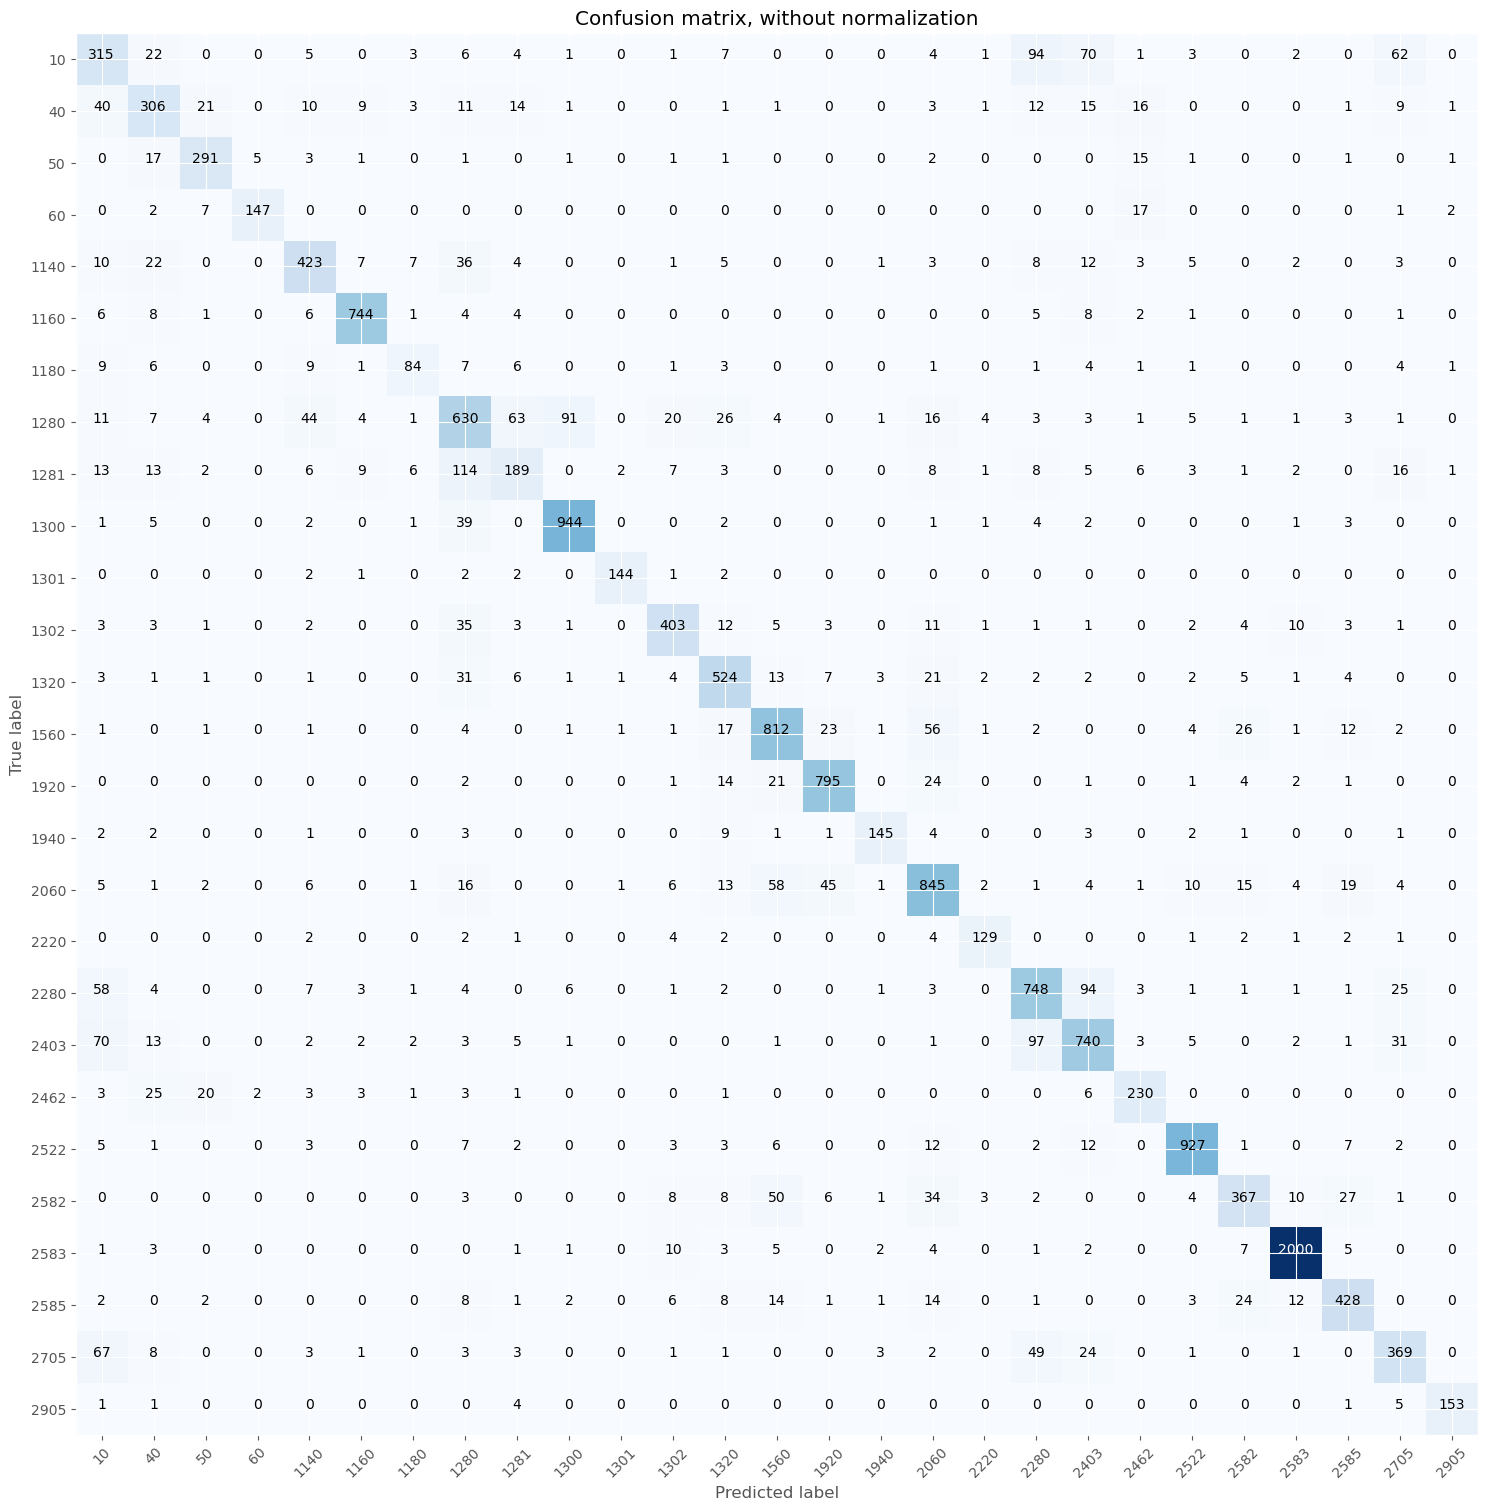

In [166]:
%matplotlib inline
cnf_matrix = confusion_matrix(y_test, y_pred_test_decision)

plt.figure(figsize=(16, 15))
plot_confusion_matrix(cnf_matrix, classes= np.unique(original_labels),
                      title='Confusion matrix, without normalization')